# Final project: Musical Genre Classification
**Author: Volodymyr Savchuk**


# Convolutional Neural Network

## Data Preprocessing

1. The mel spectrograms are represented in a form of numpy array 128  660, but we need to add one dimension, which represents that there is a single colour chanel.
2. The mel spectrograms have to be scaled to the values between 0 and 1 for making calculations quicker. 


In [12]:
import os
import librosa
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.python.keras import utils
from tensorflow.keras.utils import to_categorical

In [4]:
def extract_mel_spectrogram(directory):
    
    labels = []
    mel_specs = []
    
    
    for file in os.scandir(directory):
        
        y, sr = librosa.core.load(file)
        
        label = str(file).split('.')[0][11:]
        labels.append(label)
        
        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)
        
        if spect.shape[1] != 660:
            spect.resize(128,660, refcheck=False)
            
        mel_specs.append(spect)
        
    X = np.array(mel_specs)
    
    labels = pd.Series(labels)
    label_dict = {
        'jazz': 0,
        'reggae': 1,
        'rock': 2,
        'blues': 3,
        'hiphop': 4,
        'country': 5,
        'metal': 6,
        'classical': 7,
        'disco': 8,
        'pop': 9
    }
    y = labels.map(label_dict).values
    
    return X, y

In [5]:
X, y = extract_mel_spectrogram('/Users/vozak16/Signals/musical_genre_classification/data/wavfiles')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=.2)

In [7]:
X_train.min()

-80.0

In [8]:
X_train /= -80
X_test /= -80

In [9]:
X_train = X_train.reshape(X_train.shape[0], 128, 660, 1)
X_test = X_test.reshape(X_test.shape[0], 128, 660, 1)

In [10]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

## Defining, training and validation of the model

In [24]:
np.random.seed(23756)
tf.random.set_seed(123)

# Initiating an empty neural network
cnn_model = Sequential(name='cnn_1')

# Layer 1: CONV layer
cnn_model.add(Conv2D(filters=16,
                     kernel_size=(3,3),
                     activation='relu',
                     input_shape=(128,660,1)))

# Layer 2: Max Pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

# Layer 3: CONV layer
cnn_model.add(Conv2D(filters=32,
                     kernel_size=(3,3),
                     activation='relu'))

# Layer 4: Max Pooling layer
cnn_model.add(MaxPooling2D(pool_size=(2,4)))

 # Layer 5: Flatten layer
cnn_model.add(Flatten())

# Layer 6: Dense layer
cnn_model.add(Dense(64, activation='relu'))

# Layer 7: Dropout layer
cnn_model.add(Dropout(0.25))
 
# Layer 8: Dense layer
cnn_model.add(Dense(10, activation='softmax'))

# Compile
cnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Fit
history = cnn_model.fit(X_train,
                        y_train, 
                        batch_size=16,
                        validation_data=(X_test, y_test),
                        epochs=18)

Epoch 1/18
50/50 [==============================] - 27s 517ms/step - loss: 2.6295 - accuracy: 0.0853 - val_loss: 2.3001 - val_accuracy: 0.1000
Epoch 2/18
50/50 [==============================] - 23s 468ms/step - loss: 2.2943 - accuracy: 0.1572 - val_loss: 2.2471 - val_accuracy: 0.2400
Epoch 3/18
50/50 [==============================] - 22s 435ms/step - loss: 2.2022 - accuracy: 0.1997 - val_loss: 2.0109 - val_accuracy: 0.2600
Epoch 4/18
50/50 [==============================] - 30s 614ms/step - loss: 2.0269 - accuracy: 0.2074 - val_loss: 1.8292 - val_accuracy: 0.2850
Epoch 5/18
50/50 [==============================] - 23s 472ms/step - loss: 1.8531 - accuracy: 0.3044 - val_loss: 1.6182 - val_accuracy: 0.4050
Epoch 6/18
50/50 [==============================] - 26s 520ms/step - loss: 1.6877 - accuracy: 0.3570 - val_loss: 1.6203 - val_accuracy: 0.4200
Epoch 7/18
50/50 [==============================] - 26s 526ms/step - loss: 1.6633 - accuracy: 0.3962 - val_loss: 1.4876 - val_accuracy: 0.4650

In [25]:
cnn_model.summary()

Model: "cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 658, 16)      160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 164, 16)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 162, 32)       4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 40, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 38400)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2457664   
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0     

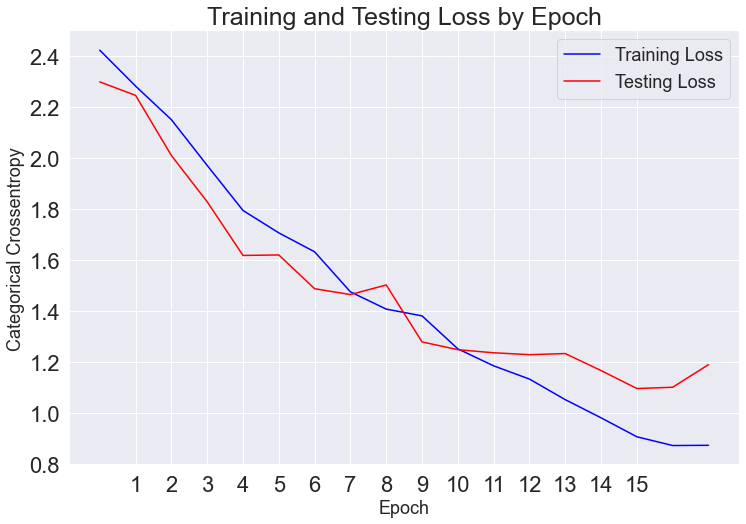

In [26]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))

plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(test_loss, label='Testing Loss', color='red')

plt.title('Training and Testing Loss by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(1,16), range(1,16))

plt.legend(fontsize = 18)

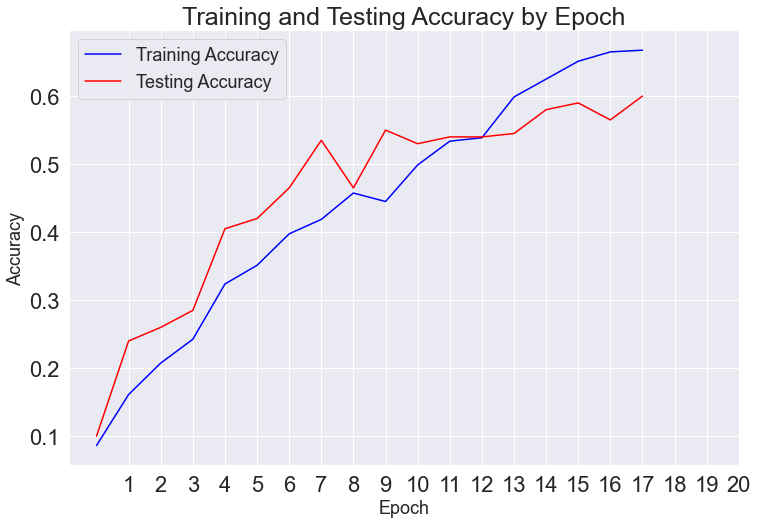

In [27]:
train_loss = history.history['accuracy']
test_loss = history.history['val_accuracy']

plt.figure(figsize=(12, 8))

plt.plot(train_loss, label='Training Accuracy', color='blue')
plt.plot(test_loss, label='Testing Accuracy', color='red')

plt.title('Training and Testing Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Accuracy', fontsize = 18)
plt.xticks(range(1,21), range(1,21))

plt.legend(fontsize = 18);

In [28]:
predictions = cnn_model.predict(X_test, verbose=1)

7/7 [==============================] - 2s 215ms/step


### Confusion Matrix


In [29]:

for i in range(10): 
    print(f'{i}: {sum([1 for target in y_test if target[i] == 1])}')

0: 20
1: 20
2: 20
3: 20
4: 20
5: 20
6: 20
7: 20
8: 20
9: 20


In [30]:
for i in range(10): 
    print(f'{i}: {sum([1 for prediction in predictions if np.argmax(prediction) == i])}')

0: 13
1: 13
2: 19
3: 13
4: 20
5: 12
6: 20
7: 23
8: 33
9: 34


In [31]:
conf_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(predictions, 1))
conf_matrix

array([[ 8,  0,  1,  2,  1,  2,  0,  3,  1,  2],
       [ 0,  8,  0,  1,  5,  1,  0,  0,  2,  3],
       [ 0,  1,  9,  1,  1,  0,  2,  0,  4,  2],
       [ 5,  0,  2,  8,  0,  2,  0,  0,  2,  1],
       [ 0,  4,  1,  0, 10,  0,  0,  0,  4,  1],
       [ 0,  0,  4,  1,  1,  6,  0,  1,  2,  5],
       [ 0,  0,  0,  0,  0,  0, 18,  0,  2,  0],
       [ 0,  0,  1,  0,  0,  0,  0, 19,  0,  0],
       [ 0,  0,  1,  0,  2,  1,  0,  0, 15,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  1, 19]])

In [32]:
confusion_df = pd.DataFrame(conf_matrix)
confusion_df

,0,1,2,3,4,5,6,7,8,9
0,8,0,1,2,1,2,0,3,1,2
1,0,8,0,1,5,1,0,0,2,3
2,0,1,9,1,1,0,2,0,4,2
3,5,0,2,8,0,2,0,0,2,1
4,0,4,1,0,10,0,0,0,4,1
5,0,0,4,1,1,6,0,1,2,5
6,0,0,0,0,0,0,18,0,2,0
7,0,0,1,0,0,0,0,19,0,0
8,0,0,1,0,2,1,0,0,15,1
9,0,0,0,0,0,0,0,0,1,19


In [33]:
labels_dict = {
    0: 'jazz',
    1: 'reggae',
    2: 'rock',
    3: 'blues',
    4: 'hiphop',
    5: 'country',
    6: 'metal',
    7: 'classical',
    8: 'disco',
    9: 'pop'
}

In [34]:
confusion_df = confusion_df.rename(columns=labels_dict)
confusion_df.index = confusion_df.columns
confusion_df

,jazz,reggae,rock,blues,hiphop,country,metal,classical,disco,pop
jazz,8,0,1,2,1,2,0,3,1,2
reggae,0,8,0,1,5,1,0,0,2,3
rock,0,1,9,1,1,0,2,0,4,2
blues,5,0,2,8,0,2,0,0,2,1
hiphop,0,4,1,0,10,0,0,0,4,1
country,0,0,4,1,1,6,0,1,2,5
metal,0,0,0,0,0,0,18,0,2,0
classical,0,0,1,0,0,0,0,19,0,0
disco,0,0,1,0,2,1,0,0,15,1
pop,0,0,0,0,0,0,0,0,1,19


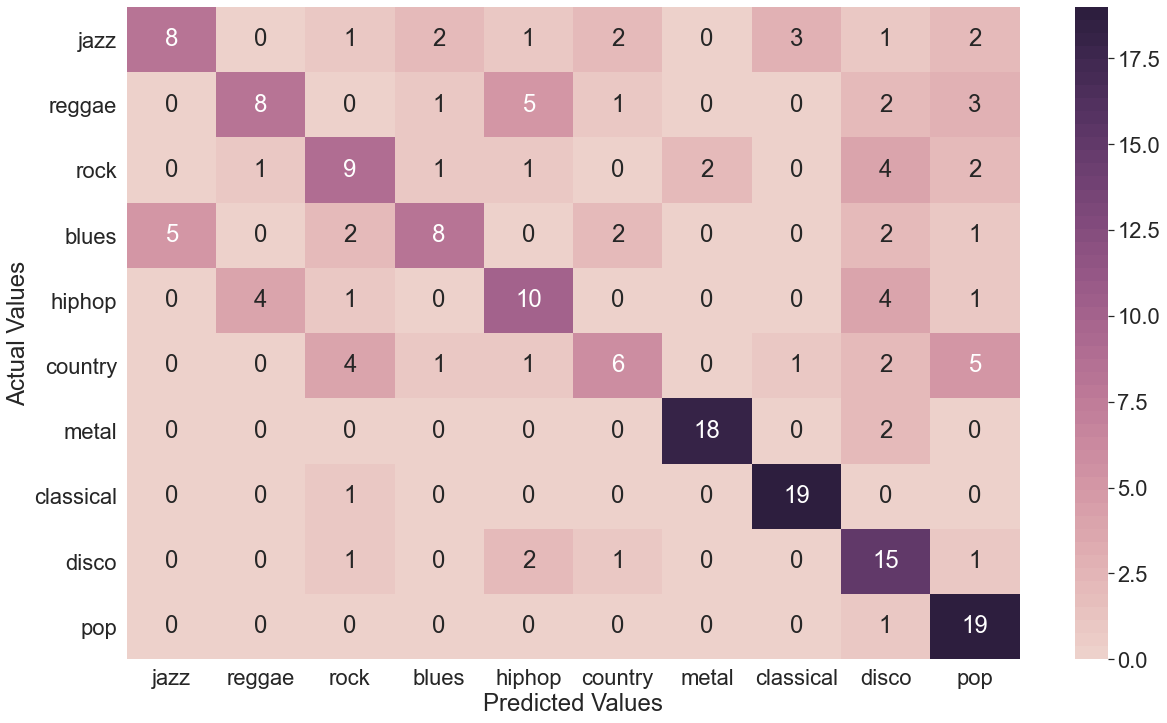

In [35]:
plt.figure(figsize= (20,12))
sns.set(font_scale = 2);
ax = sns.heatmap(confusion_df, annot=True, cmap=sns.cubehelix_palette(50));
ax.set(xlabel='Predicted Values', ylabel='Actual Values');

### Conclusion
The best CNN model has a test accuracy score of 60 % (based on a test accuracy
score). Also, this model has a training accuracy score of 64%, which means the model almost hasn't overfit. However, the results are still weighty. Looking at a confusion matrix, we can see that model mostly makes mistakes by confusing genres humans also confuse. For example, reggae vs. hiphop, blues vs. jazz.

Plans and suggestions for improvements could be to go deeper into Feature Engineering. Other components from audio samples could be used as features: Chroma(harmonic and melodic characteristics), Zero Crossing Rate, Mel-Frequency Cepstral Coefficients(MFCCs), Spectral centroid, Spectral Rolloff. All except the first one Chroma were extracted from the audio files and I plan to use it as features in the future.
